# Validation of PyPSA-Eur model inputs focusing on installed capacities and demand

## Analysis of PyPSA-Eur Model

This notebook investigates the most important input data in the **PyPSA-Eur** model. 
In particular, publicly available information about the European power system from **Ember** is compared to the data used and the results produced by the PyPSA-Eur model.

The following quantities are reviewed:

### Inputs Used by the PyPSA-Eur Model
- **Installed Generation Capacity** by Technology Type and Country
- **Electricity Demand**

### Reproducing the Results

To properly reproduce the findings presented in this notebook, please run the full **Snakemake** workflow for **PyPSA-Eur** using the config file configs/validation_config_2023.yaml 

You can find detailed installation and execution instructions in the official documentation:  
🔗 [PyPSA-Eur Installation Guide](https://pypsa-eur.readthedocs.io/en/stable/installation.html)

Alternatively, if you have access to a pre-built network, you may use that directly.

This validation step is essential for:
- Ensuring the PyPSA-Eur model's  data reflects reality.
- Highlighting discrepancies, if any, between model data and real-world statistics.
- Supporting transparency and reliability in energy system modeling.


## Preparation

### Import Packages

In [85]:
# ==============================
# Imports
# ==============================

# Core libraries
import os
import sys
import logging
from pathlib import Path
from datetime import datetime
from itertools import product

# Scientific and data processing libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import pycountry


# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs

# PyPSA
import pypsa
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches

# ==============================
# Settings
# ==============================

# Plotting styles
plt.style.use("bmh")
#sns.set(style="darkgrid")

# Logging
logger = logging.getLogger(__name__)

# Pandas display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

# Custom plotting parameters
max_node_size = 1.0  # maximum size of a node for plotting purposes


### Loading the Solved PyPSA Network and Ember statistics

To load the solved PyPSA-Eur network, make sure your file path points to the correct `.nc` file generated by the Snakemake workflow.

If your project follows the default directory structure, make sure you use the correct path to the network.

The **Ember** data can be downloaded from [here](https://storage.googleapis.com/emb-prod-bkt-publicdata/public-downloads/yearly_full_release_long_format.csv)

Place the dataset in the following location: `Ember-Flexibility-Study/validation/ember_data/yearly_full_release_long_format.csv`



In [86]:
year = 2023

# Path to the solved network
network_path = f"../results/validation_{year}/networks/base_s_39_elec_.nc"
n = pypsa.Network(network_path)

# Downlad and filter Ember data for capacities
ember_data = pd.read_csv("../validation/ember_data/yearly_full_release_long_format.csv")

exclude_areas = [
    "Belarus", "Gibraltar", "Iceland", "Kosovo", "Moldova", "Russian Federation (the)", "Malta", "Cyprus"
]
ember_capacity = ember_data.query(
    f"Year == {year} and Continent == 'Europe' and Category == 'Capacity' and Subcategory == 'Fuel'"
).copy()
ember_capacity = ember_capacity[~ember_capacity.Area.isin(exclude_areas)]


# Downlad and filter Ember data for load
ember_load = pd.read_csv("../validation/ember_data/europe_monthly_full_release_long_format.csv")
# Keep only Europe
ember_load_europe = ember_load[ember_load["Continent"] == "Europe"].copy()

ember_load_europe = ember_load_europe[ember_load_europe["Date"].str.startswith(str(year))]



INFO:pypsa.io:Imported network base_s_39_elec_.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


### Plot Network

Simple plot to show the number and the distribution of the nodes

/tmp/ipykernel_98944/1841463972.py:1: DeprecatedWarning: plot is deprecated. Use `n.plot.map()` as a drop-in replacement instead.
  n.plot(bus_sizes=0.3, margin=0.2);


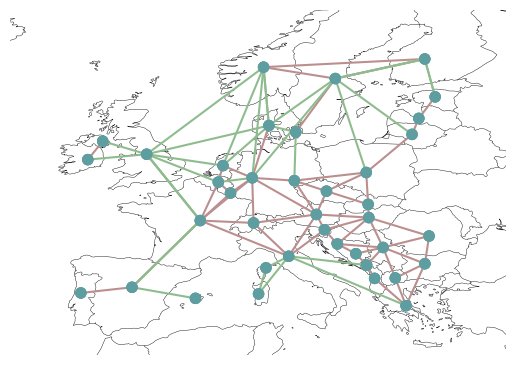

In [87]:
n.plot(bus_sizes=0.3, margin=0.2);

## Visual Representation of the Current Capacity of the Energy System

/tmp/ipykernel_98944/3740308323.py:26: DeprecatedWarning: plot is deprecated. Use `n.plot.map()` as a drop-in replacement instead.
  n.plot(
/home/user/miniconda3/envs/pypsa-eur_Ember-Flexibility-Study/lib/python3.12/site-packages/pypsa/plot/accessor.py:34: DeprecationWarning: `color_geomap` is deprecated as an argument to `plot`; use `geomap_colors` instead.
  return plot(self.n, *args, **kwargs)
/tmp/ipykernel_98944/3740308323.py:55: DeprecationWarning: The namespace `pypsa.plot.add_legend_circles` is deprecated and will be removed in a future version. Please use the new namespace `pypsa.plot.maps.static.add_legend_circles` instead.
  add_legend_circles(
/home/user/miniconda3/envs/pypsa-eur_Ember-Flexibility-Study/lib/python3.12/site-packages/pypsa/plot/maps/static.py:1678: UserWarning: When combining n.plot() with other plots on a geographical axis, ensure n.plot() is called first or the final axis extent is set initially (ax.set_extent(boundaries, crs=crs)) for consistent legend ci

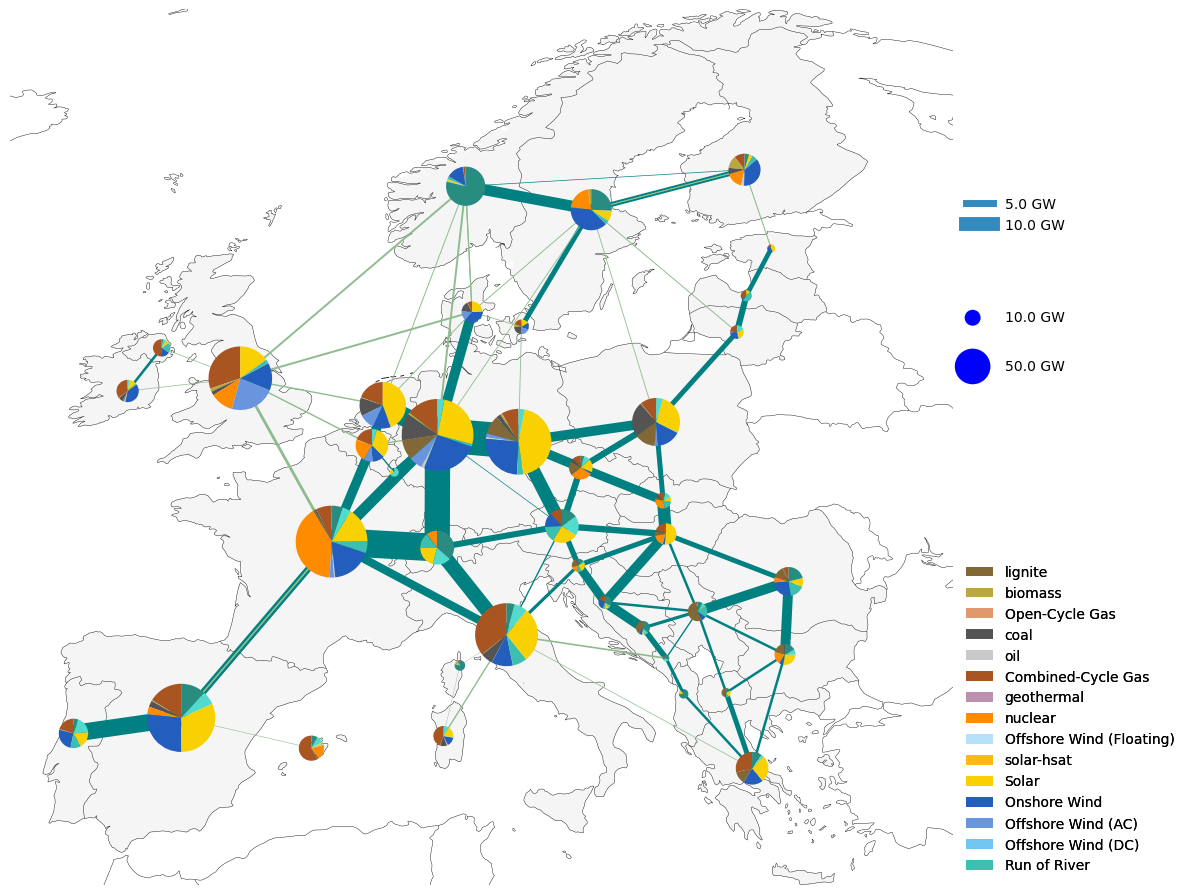

In [88]:

# Load regions
regions_onshore_path = "../resources/validation_2023/country_shapes.geojson"
regions_onshore = gpd.read_file(regions_onshore_path)

# Fix missing or empty colors in carriers
n.carriers['color'] = n.carriers['color'].fillna('gray')  # Replace NaN with 'gray'
n.carriers.loc[n.carriers['color'] == '', 'color'] = 'gray'  # Replace empty strings with 'gray'

# Scale settings (adjusted to reduce node sizes)
bus_scale = 5e4  # Increased from 6e3 to make nodes smaller
line_scale = 1e3  # Keep as is, since only nodes need adjustment

# Legend settings
bus_sizes = [10000, 50000]  # in MW
line_sizes = [5000, 10000]  # in MW

# Plotting
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})

# Calculate bus sizes based on generator and storage capacities
gen = n.generators[n.generators.carrier != "load"].groupby(["bus", "carrier"]).p_nom.sum()
sto = n.storage_units.groupby(["bus", "carrier"]).p_nom.sum()
buses = pd.concat([gen, sto])

with plt.rc_context({"patch.linewidth": 0.}):
    n.plot(
        bus_sizes=buses / bus_scale,  # Use adjusted bus_scale
        bus_alpha=1.0,
        line_widths=n.lines.s_nom_opt / line_scale,
        link_widths=n.links.p_nom_opt / line_scale,
        line_colors="teal",
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )

# Plot regions
regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)

# Set extent
ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])

# Legend settings
legend_kwargs = {"loc": "upper left", "frameon": False}
legend_circles_dict = {"bbox_to_anchor": (1, 0.67), "labelspacing": 2.5, **legend_kwargs}

# Add legends
add_legend_circles(
    ax,
    [s / bus_scale for s in bus_sizes],  # Legend sizes scaled by bus_scale
    [f"{s / 1000} GW" for s in bus_sizes],
    legend_kw=legend_circles_dict,
)

add_legend_lines(
    ax,
    [s / line_scale for s in line_sizes],
    [f"{s / 1000} GW" for s in line_sizes],
    legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
)

# Only include carriers that exist in n.generators.carrier
existing_carriers = n.generators.carrier.unique()
carriers_legend = n.carriers.loc[n.carriers.index.isin(existing_carriers)]

add_legend_patches(
    ax,
    carriers_legend.color,
    carriers_legend.nice_name,
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc": "lower left"},
)

# Tight layout
fig.tight_layout()

# Show plot
plt.show()

### Installed Capacity from the PyPSA-Eur Model

The installed generation capacity in the PyPSA-Eur model is calculated by grouping all generation units by technology type ("carrier") and summing their nominal capacities. This provides an overview of the distribution of power generation technologies across Europe in the model and allows for comparison with external datasets (e.g., Ember) to validate the model’s representation of Europe’s generation capacity.




### Comparing Installed Generation Capacity: ENTSO-E vs PyPSA-Eur

This analysis compares the total installed electricity generation capacity by energy carrier between the Ember dataset and the PyPSA-Eur model.

- **Data Harmonization:** Both datasets are mapped to common broad technology categories (e.g., Nuclear, Fossil Fuels, Hydro, Solar, Wind) to enable a meaningful comparison.
- **Data Aggregation:** Installed capacities are aggregated by carrier in gegawatts (GW) for both ENTSO-E and PyPSA-Eur.
- **Full Data:** Tables showing all data from both sources for the chosen years are presented below.
- **Visualization:** A side-by-side bar chart is generated to visually compare the installed capacities for each technology.

In [89]:

# Map ISO 3 code to ISO 2 code
def iso3_to_iso2(iso3):
    try:
        return pycountry.countries.get(alpha_3=iso3).alpha_2
    except:
        return None

ember_capacity["ISO"] = ember_capacity["ISO 3 code"].apply(iso3_to_iso2)
ember_capacity = ember_capacity[["ISO", "Variable", "Value", "Unit"]]
ember_capacity = ember_capacity.pivot_table(index="ISO", columns="Variable", values="Value").fillna(0)
ember_capacity

Variable,Bioenergy,Coal,Gas,Hydro,Nuclear,Other Fossil,Other Renewables,Solar,Wind
ISO,,,,,,,,,
AL,0.00,0.00,0.00,2.52,0.00,0.10,0.00,0.21,0.00
AT,0.98,0.00,4.92,14.95,0.00,0.63,0.25,6.33,3.90
BA,0.01,2.09,0.00,1.84,0.00,0.00,0.00,0.21,0.14
BE,0.70,0.00,6.95,0.12,3.92,0.19,0.14,8.35,5.45
BG,0.08,5.11,1.18,2.49,2.01,0.00,0.00,2.91,0.70
CH,0.03,0.00,0.23,16.22,2.96,0.54,0.20,6.09,0.09
CZ,0.79,7.46,1.72,1.12,4.29,0.03,0.03,3.25,0.34
DE,8.86,39.07,33.87,5.61,0.00,1.89,1.06,74.88,69.49
DK,1.79,1.56,0.72,0.01,0.00,0.65,0.17,3.53,7.28


In [90]:
def merge_and_replace(df, new_col, cols_to_merge, drop_original=True):
    """Merge columns in cols_to_merge into new_col, optionally drop originals."""
    df[new_col] = df[cols_to_merge].sum(axis=1)
    if drop_original:
        df = df.drop(columns=cols_to_merge, errors="ignore")
    return df

# Create a summary table of installed capacity by carrier from the PyPSA-Eur network
pypsa_table = n.generators.groupby("carrier")["p_nom"].sum().reset_index()
pypsa_table.columns = ["Category", "Value"]
pypsa_table["Unit"] = "MW"

# Pivot the generator data to get installed capacity per country (bus) and technology (carrier)
pypsa_country_tech = n.generators.groupby(['bus', 'carrier'])['p_nom'].sum().unstack(fill_value=0).reset_index()
pypsa_country_tech['country'] = pypsa_country_tech['bus'].str.extract(r'(^[A-Z]{2})')

# Automatically map each bus to its country code (first two letters)
pypsa_country_tech['country'] = pypsa_country_tech['bus'].str[:2]

# Add storage units to the country-technology table
sto_country_tech = n.storage_units.groupby(['bus', 'carrier'])['p_nom'].sum().unstack(fill_value=0).reset_index()
sto_country_tech['country'] = sto_country_tech['bus'].str[:2]

# Merge generator and storage unit tables
pypsa_country_tech = pd.concat([pypsa_country_tech, sto_country_tech], ignore_index=True)
pypsa_country_tech['country'] = pypsa_country_tech['bus'].str[:2]

pypsa_country_tech_merged = pypsa_country_tech.groupby('country').sum(numeric_only=True).reset_index()

# Merge and replace technology columns using the helper function
wind_cols = [col for col in pypsa_country_tech_merged.columns if col.startswith("onwind") or col.startswith("offwind")]
solar_cols = [col for col in pypsa_country_tech_merged.columns if col.startswith("solar")]

pypsa_country_tech_merged = merge_and_replace(pypsa_country_tech_merged, "Wind", wind_cols)
pypsa_country_tech_merged = merge_and_replace(pypsa_country_tech_merged, "Solar", solar_cols)
pypsa_country_tech_merged = merge_and_replace(pypsa_country_tech_merged, "Gas", ["CCGT", "OCGT"])
pypsa_country_tech_merged = merge_and_replace(pypsa_country_tech_merged, "Coal", ["coal", "lignite"])
pypsa_country_tech_merged = merge_and_replace(pypsa_country_tech_merged, "Hydro", ["hydro", "ror", "PHS"])
pypsa_country_tech_merged = merge_and_replace(pypsa_country_tech_merged, "Other Fossil", ["oil"])
pypsa_country_tech_merged = merge_and_replace(pypsa_country_tech_merged, "Nuclear", ["nuclear"])
pypsa_country_tech_merged = merge_and_replace(pypsa_country_tech_merged, "Other Renewables", ["geothermal"])
pypsa_country_tech_merged = merge_and_replace(pypsa_country_tech_merged, "Bioenergy", ["biomass"])

pypsa_country_tech_merged = pypsa_country_tech_merged.set_index("country").div(1000).round(2)
pypsa_country_tech_merged


carrier,Wind,Solar,Gas,Coal,Hydro,Other Fossil,Nuclear,Other Renewables,Bioenergy
country,,,,,,,,,
AL,0.23,0.29,0.00,0.00,1.74,0.00,0.00,0.00,0.00
AT,3.98,6.83,3.37,0.00,14.12,0.00,0.00,0.00,0.00
BA,0.44,0.27,0.00,1.91,2.21,0.00,0.00,0.00,0.00
BE,5.50,8.55,5.08,0.00,1.38,0.13,5.92,0.00,0.08
BG,0.70,2.94,0.09,2.31,2.90,0.00,2.08,0.00,0.00
CH,0.09,5.84,0.06,0.00,19.77,0.00,2.97,0.00,0.00
CZ,0.34,2.50,1.58,3.53,1.89,0.00,4.16,0.00,0.00
DE,70.71,81.74,27.61,39.80,12.00,2.66,0.00,0.00,2.30
DK,7.48,3.53,1.81,3.08,0.00,0.00,0.00,0.00,0.38


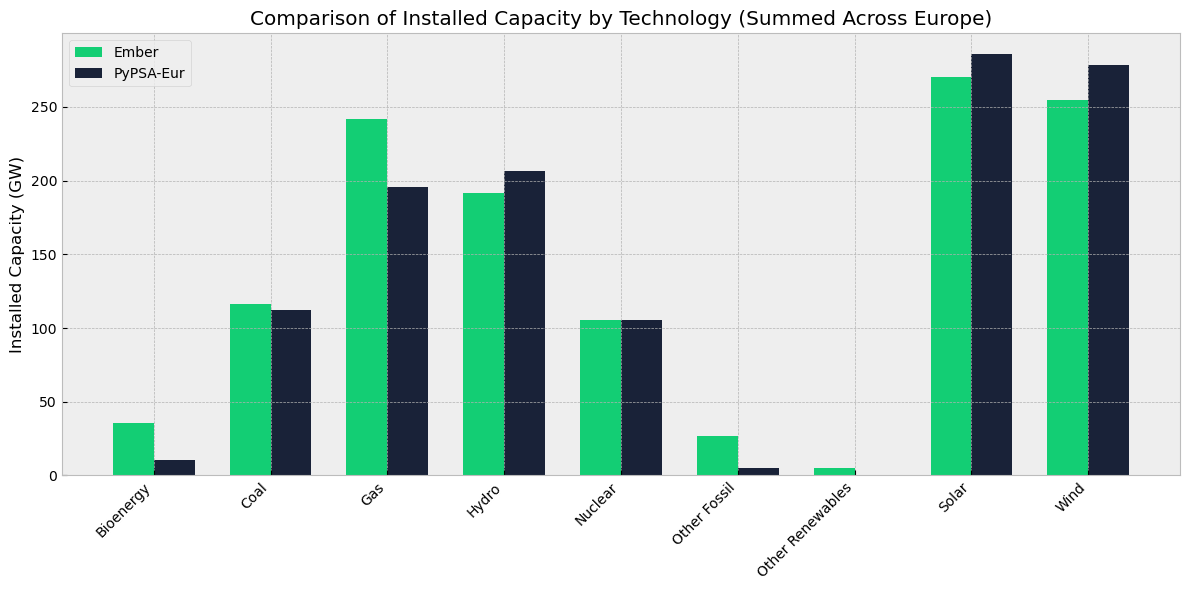

In [91]:
# Sum capacities for each technology across all countries for both datasets
ember_totals = ember_capacity.sum(axis=0)
pypsa_totals = pypsa_country_tech_merged.sum(axis=0)

# Get the union of technology names
all_techs = sorted(set(ember_totals.index) | set(pypsa_totals.index))

# Prepare data for plotting
ember_vals = [ember_totals.get(tech, 0) for tech in all_techs]
pypsa_vals = [pypsa_totals.get(tech, 0) for tech in all_techs]

# Plot side-by-side bar chart
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.35
x = np.arange(len(all_techs))

ax.bar(x - width/2, ember_vals, width, label='Ember', color='#13ce74')
ax.bar(x + width/2, pypsa_vals, width, label='PyPSA-Eur', color='#192238')

ax.set_xticks(x)
ax.set_xticklabels(all_techs, rotation=45, ha='right')
ax.set_ylabel('Installed Capacity (GW)')
ax.set_title('Comparison of Installed Capacity by Technology (Summed Across Europe)')
ax.legend()
plt.tight_layout()
plt.show()

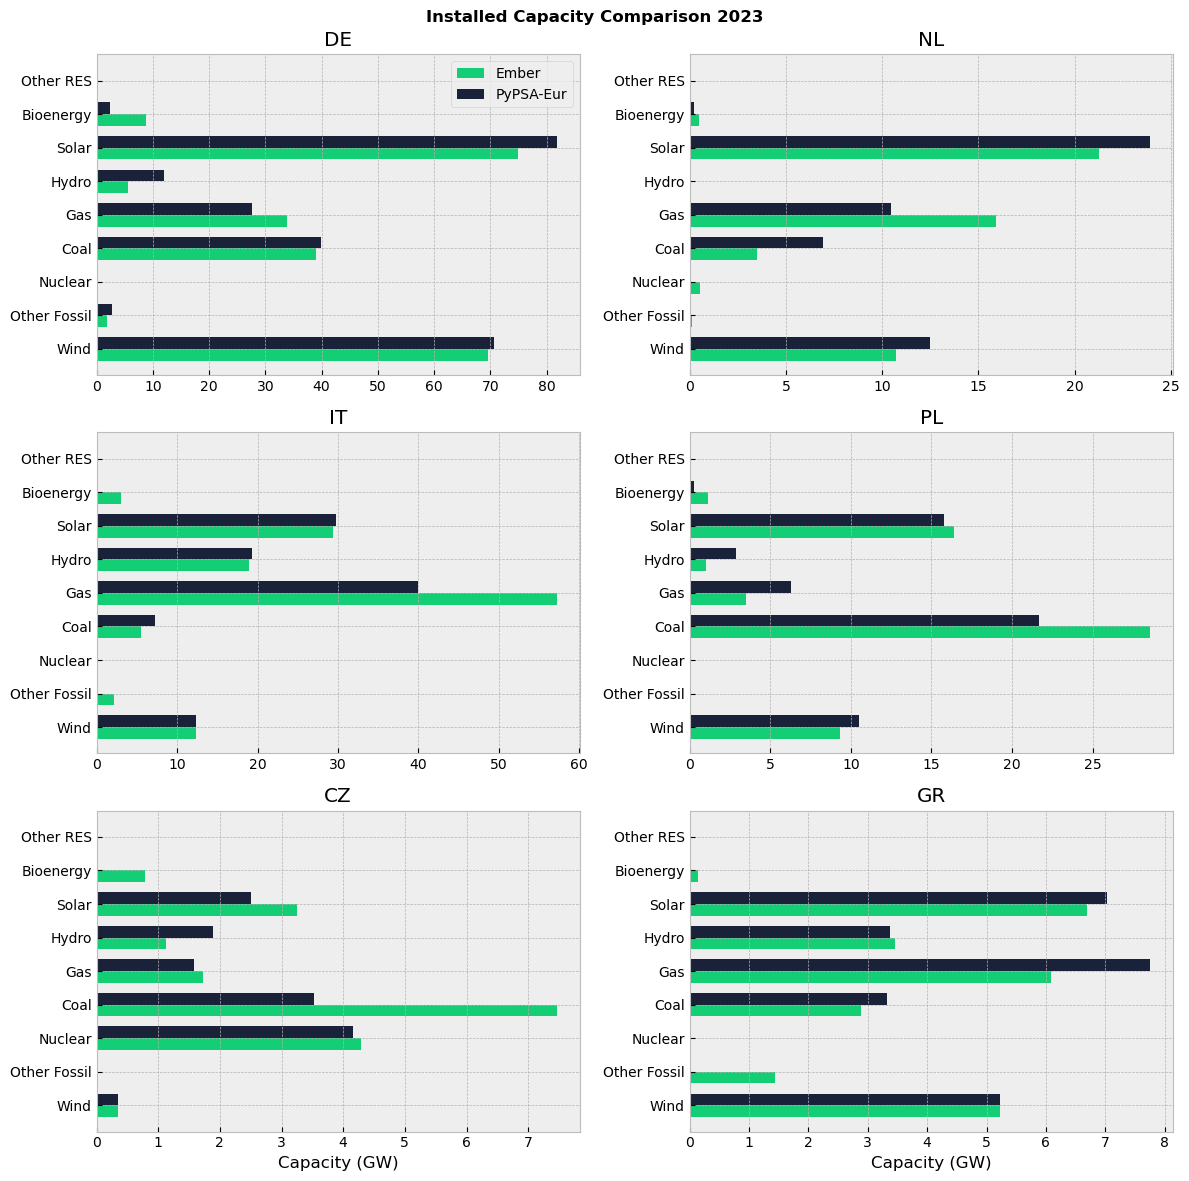

In [92]:

def plot_capacity_comparison_horizontal(countries, ember_capacity, pypsa_country_tech_merged):
    """
    Plot 6 subplots (3 rows x 2 columns), each comparing technology capacities
    between ember_capacity and pypsa_country_tech_merged for a given country as horizontal bar plots.
    """
    import matplotlib.pyplot as plt

    n = min(len(countries), 6)
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    axes = axes.flatten()

    for idx, country in enumerate(countries[:6]):
        ax = axes[idx]
        ember_row = ember_capacity.loc[country] if country in ember_capacity.index else None
        pypsa_row = pypsa_country_tech_merged.loc[country] if country in pypsa_country_tech_merged.index else None

        if ember_row is not None and pypsa_row is not None:
            techs = sorted(set(ember_row.index) | set(pypsa_row.index))
            techs = {t if t != "Other Renewables" else "Other RES" for t in techs}

            ember_vals = [ember_row.get(tech, 0) for tech in techs]
            pypsa_vals = [pypsa_row.get(tech, 0) for tech in techs]

            y = np.arange(len(techs))
            height = 0.35

            ax.barh(y - height/2, ember_vals, height, label='Ember', color='#13ce74')
            ax.barh(y + height/2, pypsa_vals, height, label='PyPSA-Eur', color='#192238')
            ax.set_yticks(y)
            ax.set_title(f"{country} Capacity Comparison")

            ax.set_yticklabels(techs)#, fontsize=9)
            if idx in [4, 5]:
                ax.set_xlabel("Capacity (GW)")

            if idx == 0:
                ax.legend(loc="upper right")
            ax.set_title(country)
            fig.suptitle("Installed Capacity Comparison {}".format(year), weight="bold")
    plt.tight_layout()
    plt.show()

plot_capacity_comparison_horizontal(
    countries=["DE", "NL", "IT", "PL", "CZ", "GR"],
    ember_capacity=ember_capacity,
    pypsa_country_tech_merged=pypsa_country_tech_merged
)



## Comparison of Electricity Demand Between PyPSA-Eur and Ember

### In this section, we examine the electrical demand input used in the PyPSA-Eur simulations and compare it with real-world statistics from **Ember**.

In this step we use the **PyPSA** network and **Ember** data downloaded from [here](https://storage.googleapis.com/emb-prod-bkt-publicdata/public-downloads/europe_monthly_full_release_long_format.csv).

Place the data in the location: `Ember-Flexibility-Study/validation/ember_data/europe_monthly_full_release_long_format.csv`



In [93]:


# Change ISO 3 code to ISO (using the same mapping as in ember_capacity)

def iso3_to_iso2(iso3):
    try:
        return pycountry.countries.get(alpha_3=iso3).alpha_2
    except:
        return None

ember_load_europe["ISO"] = ember_load_europe["ISO 3 code"].apply(iso3_to_iso2)

# Filter using the previous dataset ember_capacity (keep only ISOs present in ember_capacity)
ember_load_europe = ember_load_europe[ember_load_europe["ISO"].isin(ember_capacity.index)]
# Keep only rows where Date is in 2023


ember_load_europe = ember_load_europe[ember_load_europe["Unit"] == "TWh"]
ember_load_europe = ember_load_europe[ember_load_europe["Subcategory"] == "Demand"]


# Keep only columns ISO, Variable, Value, and Unit
ember_load_europe = ember_load_europe[["ISO", "Date", "Variable", "Value", "Unit"]]

# Aggregate monthly Value to yearly per ISO and Variable
ember_demand_yearly = (
    ember_load_europe.groupby(["ISO", "Variable"], as_index=False)["Value"].sum()
)
ember_demand_yearly["Unit"] = "TWh"
ember_demand_yearly = ember_demand_yearly.set_index("ISO").drop(columns=["Unit", "Variable"])

pypsa_loads = n.loads_t.p.groupby(lambda col: col[:2], axis=1).sum()
pypsa_loads_yearly = pypsa_loads.sum(axis=0).to_frame(name="Value")
pypsa_loads_yearly = (pypsa_loads_yearly/1e6).round()


/tmp/ipykernel_98944/831671878.py:30: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  pypsa_loads = n.loads_t.p.groupby(lambda col: col[:2], axis=1).sum()


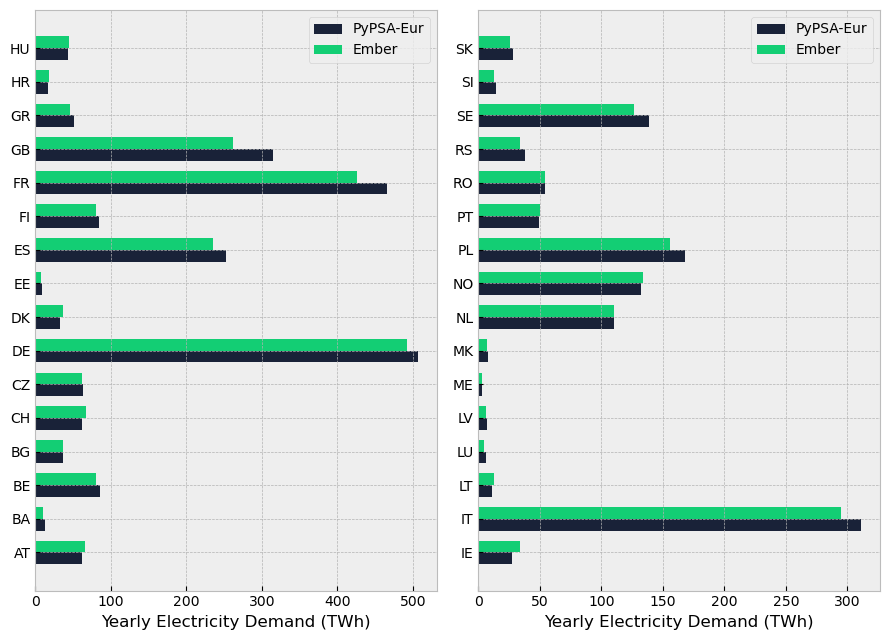

In [94]:
# Prepare data for comparison: sum yearly demand per country for both datasets
pypsa_loads_yearly_flat = pypsa_loads_yearly["Value"]
ember_demand_yearly_flat = ember_demand_yearly["Value"]

# Align indices (countries) for a fair comparison
common_countries = pypsa_loads_yearly_flat.index.intersection(ember_demand_yearly_flat.index)
pypsa_vals = pypsa_loads_yearly_flat.loc[common_countries]
ember_vals = ember_demand_yearly_flat.loc[common_countries]

# Create a DataFrame for plotting
df_compare = pd.DataFrame({
    "PyPSA-Eur": pypsa_vals,
    "Ember": ember_vals
}, index=common_countries)

# Split countries into two halves
n_countries = len(df_compare)
mid = n_countries // 2
countries1 = df_compare.index[:mid]
countries2 = df_compare.index[mid:]

fig, axes = plt.subplots(1, 2, figsize=(9, 6.5), sharey=False)

for ax, countries, title in zip(
    axes, [countries1, countries2], ["Countries 1", "Countries 2"]
):
    y = np.arange(len(countries))
    ax.barh(y - width/2, df_compare.loc[countries, "PyPSA-Eur"], height=width, label='PyPSA-Eur', color='#192238')
    ax.barh(y + width/2, df_compare.loc[countries, "Ember"], height=width, label='Ember', color='#13ce74')
    ax.set_yticks(y)
    ax.set_yticklabels(countries)
    ax.set_xlabel('Yearly Electricity Demand (TWh)')
    #ax.set_title(f'Comparison by Country (2023) - {title}')
    ax.legend()


plt.tight_layout()
plt.show()
